# Time Series Cross-Validation with Embargo

This notebook demonstrates how to implement and apply a custom cross-validation splitter for time series data, featuring an **embargo period** to prevent information leakage between training and test sets.

**Motivation:**  
In time series and financial data, classical cross-validation may lead to lookahead bias and over-optimistic model evaluation.  
Adding an embargo period ensures strict separation between train and test samples, simulating a more realistic forecasting scenario.

We will:
- Generate synthetic time series data.
- Implement the `TimeSeriesEmbargoCV` splitter.
- Visualize the effect of the embargo period.
- Apply the custom CV in a scikit-learn pipeline.


In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
import seaborn as sns

from sklearn.model_selection import BaseCrossValidator, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## Generate Synthetic Data

We first create synthetic time series data to demonstrate the cross-validation strategy.

In [153]:
np.random.seed(42)
X = np.array(range(1, 101))
trend = np.linspace(1, 120, len(x))
noise = np.random.normal(2, 5, len(x)) - np.random.randint(0, 20, size=len(x))
y = np.sin(x) + trend + noise

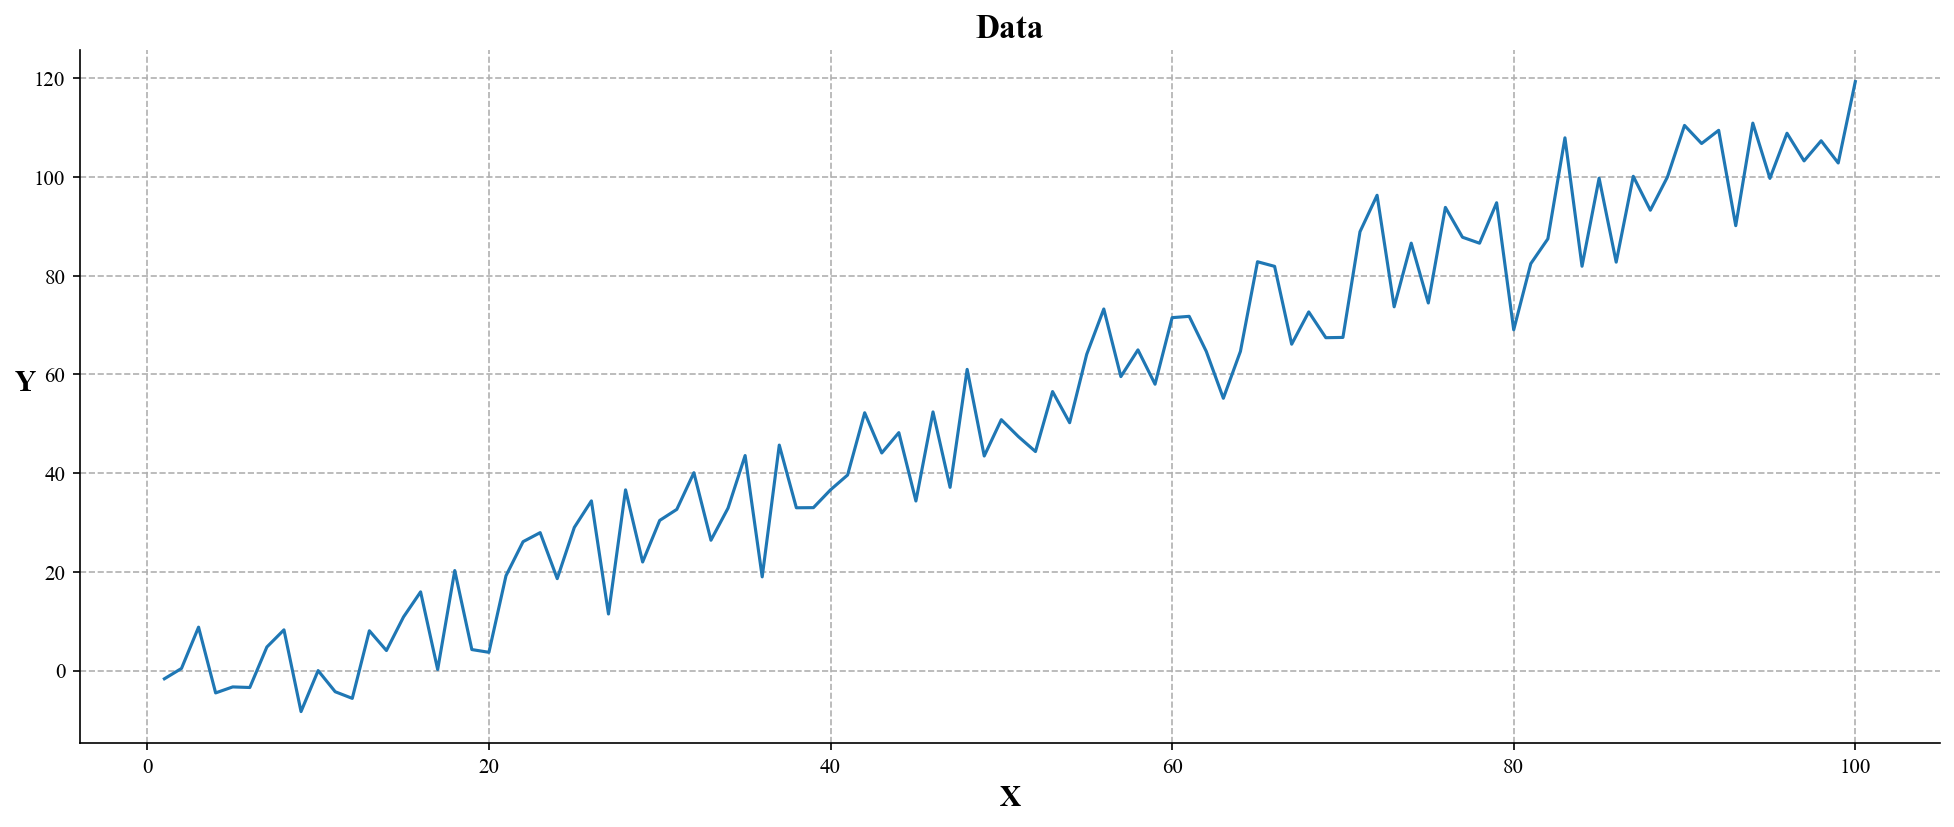

In [154]:
plt.figure(figsize=(16,6), dpi=150)
plt.plot(X, y)
plt.xlabel('X', size=14, weight='bold')
plt.ylabel('Y', size=14, weight='bold', rotation=0)
plt.title('Data', weight='bold', size=16)
sns.despine()
plt.grid(ls='--')
sns.despine()
plt.show()

## Create a Custom Time Series Cross-Validator

Here, we define `TimeSeriesEmbargoCV`, a cross-validator that introduces an embargo period between training and test sets to avoid data leakage.  
This implementation is compatible with scikit-learn's API.

In [174]:
class TimeSeriesEmbargoCV(BaseCrossValidator):
    """
    Time Series cross-validator with embargo period to prevent leakage.

    This cross-validator splits time series data into sequential train and test folds,
    introducing an embargo period (a gap) between train and test sets to prevent data leakage.
    The embargo_size specifies the number of samples to skip between the train and test sets
    in each fold. Designed for use-cases where temporal dependency may lead to lookahead bias,
    such as in financial modeling or forecasting tasks.

    Parameters
    ----------
    cv : int, default=5
        Number of folds.

    embargo_size : int, default=0
        Number of samples to exclude (the embargo period) between train and test sets
        in each fold.

    Examples
    --------
    >>> cv = TimeSeriesEmbargoCV(cv=5, embargo_size=3)
    >>> for train_idx, test_idx in cv.split(X):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    """

    def __init__(self, cv=5, embargo_size=0):
        """
        Initialize the cross-validator.

        Parameters
        ----------
        cv : int, default=5
            Number of folds.

        embargo_size : int, default=0
            Number of samples to exclude (the embargo period) between train and test sets.
        """
        if not isinstance(cv, int):
            raise ValueError("'cv' must be int")
        if not isinstance(embargo_size, int):
            raise ValueError("'embargo_size' must be int")
        self.n_splits = cv
        self.embargo_size = embargo_size

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        Returns the number of splitting iterations in the cross-validator.

        Parameters
        ----------
        X : array-like, shape (n_samples, ...)
            Always ignored, exists for compatibility.

        y : array-like, shape (n_samples, ...)
            Always ignored, exists for compatibility.

        groups : array-like, with shape (n_samples,), optional
            Always ignored, exists for compatibility.

        Returns
        -------
        n_splits : int
            Number of folds/splits.
        """
        n_samples = len(X)
        fold_size = int(n_samples / self.n_splits)
        n_possible_splits = (n_samples - self.embargo_size) // fold_size
        return min(self.n_splits, n_possible_splits)

    def split(self, X=None, y=None, groups=None):
        """
        Generate indices to split data into training and test set for each fold.

        Parameters
        ----------
        X : array-like, shape (n_samples, ...)
            The data to split.

        y : array-like, shape (n_samples, ...)
            Always ignored, exists for compatibility.

        groups : array-like, with shape (n_samples,), optional
            Always ignored, exists for compatibility.

        Yields
        ------
        train_indices : ndarray
            The training set indices for that split.

        test_indices : ndarray
            The testing set indices for that split.
        """
        n_samples = len(X)
        fold_size = int(n_samples / self.n_splits)
        n_actual_splits = self.get_n_splits(X)
        for i in range(n_actual_splits):
            train_start_idx = i * fold_size
            train_end_idx = i * fold_size + fold_size
            test_start_idx = train_end_idx + self.embargo_size
            test_end_idx = test_start_idx + fold_size - self.embargo_size
            if test_end_idx > n_samples:
                break
            train_indices = np.arange(train_start_idx, train_end_idx)
            test_indices = np.arange(test_start_idx, test_end_idx)
            yield train_indices, test_indices

## Illustrate Fold Splits and Embargo Period

We now illustrate how the custom cross-validator divides the data, showing the embargo window between train and test sets for each fold.


In [169]:
tse = TimeSeriesEmbargoCV(cv=5, embargo_size=5)
tse

TimeSeriesEmbargoCV(cv=None, embargo_size=5)

In [170]:
for train_idx, test_idx in tse.split(X):
    print("Train Index:", train_idx, "Test Index:", test_idx)

Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] Test Index: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Train Index: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] Test Index: [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Train Index: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59] Test Index: [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
Train Index: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79] Test Index: [85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


## Full Machine Learning Pipeline with scikit-learn

Finally, we show how to integrate the custom cross-validator into a full sklearn pipeline for hyperparameter tuning using `GridSearchCV`.

In [175]:
forest = RandomForestRegressor()
params = {'max_depth': [2,4,6],
         'min_samples_split': [2,3]}

gridsearch = GridSearchCV(estimator=forest,
                         param_grid = params,
                         cv=tse)
gridsearch

GridSearchCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'min_samples_split': [2, 3]})

In [176]:
gridsearch.fit(x.reshape(-1, 1),
              y)

GridSearchCV(cv=TimeSeriesEmbargoCV(cv=None, embargo_size=5),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'min_samples_split': [2, 3]})

## Conclusion

This notebook demonstrated the implementation and application of a custom time series cross-validator with an embargo period.  
We covered:
- The motivation for using embargo in time series cross-validation.
- How to construct and visualize such a splitter.
- Integration with scikit-learn pipelines.

While we did not evaluate model performance or compare results with standard cross-validation, the notebook provides a ready-to-use framework for more realistic and robust time series validation.

**You are encouraged to experiment further by analyzing model performance, testing different embargo sizes, or comparing with alternative validation strategies.**

## References

- De Prado, M. L. (2018). *Advances in Financial Machine Learning.* Wiley.
- [Scikit-learn Custom Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html#custom-cross-validation)